In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
import math
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import shap


In [2]:
FILE_IN = "./data/combined_data.csv"
df = pd.read_csv(FILE_IN)
print("Total number: ",len(df))
df.head()

Total number:  52714


/Users/Strawberry/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,zpid,street,zip,city,state,latitude,longitude,FIPScounty,propertyType,...,edu_mean,edu_max,edu_min,pop_2012,pop_2013,pop_2014,pop_2015,pop_2016,pop_2017,pop_2018
0,0,251033583,8017 Bestride Bnd,78744,AUSTIN,TX,30.186200,-97.738800,48453.0,NaN,...,55.667035,63.07768,48.25639,854841,875463,901734,921545,939768,951750,964254
1,1,29343368,4191 Westlake Dr,78746,AUSTIN,TX,30.333213,-97.799519,48453.0,NaN,...,92.643080,92.64308,92.64308,854841,875463,901734,921545,939768,951750,964254
2,2,29349366,6203 Shadow Mountain Dr,78731,AUSTIN,TX,30.348746,-97.760890,48453.0,NaN,...,6.943352,16.22703,3.62122,854841,875463,901734,921545,939768,951750,964254
3,3,29467905,5304 China Berry Rd,78744,AUSTIN,TX,30.193234,-97.737353,48453.0,NaN,...,55.667035,63.07768,48.25639,854841,875463,901734,921545,939768,951750,964254
4,4,29499672,8968 W Hove Loop,78749,AUSTIN,TX,30.200092,-97.854377,48453.0,NaN,...,42.879144,96.09233,4.95380,854841,875463,901734,921545,939768,951750,964254


In [3]:
# from crime number to crime rate
columns = df.columns[42:210].values

for var in columns:
    year = var.split("_")[1]
    df[var] = df[var]/df["pop_"+year]

In [4]:
# data preprocessing
target = "zestimatePrice"
features = np.array(['finishedSqFt', 'weather_jul', 'weather_aug', 'yearBuilt',
       'Wage_AVG_14', 'Wage_MED_14', 'Wage_AVG_15', 'Wage_MED_15',
       'Wage_MED_13', 'Wage_MED_12', 'edu_max', 'bathrooms', 'bedrooms',
       'edu_mean', 'edu_min', 'edu_median', 'actual_2015_violent-crime',
       'actual_2017_arson', 'weather_mar', 'actual_2013_rape-legacy'])

colums = np.append(features, [target])
df_data = df[colums]

print("total number: ", len(df_data))
df_data = df_data.dropna()
print("number without nan: ",len(df_data))

df_data.head()

total number:  52714
number without nan:  52322


,finishedSqFt,weather_jul,weather_aug,yearBuilt,Wage_AVG_14,Wage_MED_14,Wage_AVG_15,Wage_MED_15,Wage_MED_13,Wage_MED_12,...,bathrooms,bedrooms,edu_mean,edu_min,edu_median,actual_2015_violent-crime,actual_2017_arson,weather_mar,actual_2013_rape-legacy,zestimatePrice
0,2487.0,24.71,25.8,2019.0,73016.0,66331.0,75089.0,65229.0,66331.0,70175.0,...,4.0,4,55.667035,48.25639,55.667035,0.003795,0.00008,23.7,0.000248,401942
1,6135.0,24.71,25.8,2002.0,73016.0,66331.0,75089.0,65229.0,66331.0,70175.0,...,6.0,5,92.643080,92.64308,92.643080,0.003795,0.00008,23.7,0.000248,2019998
2,2868.0,24.71,25.8,1977.0,73016.0,66331.0,75089.0,65229.0,66331.0,70175.0,...,4.0,5,6.943352,3.62122,5.214815,0.003795,0.00008,23.7,0.000248,807984
3,1485.0,24.71,25.8,2000.0,73016.0,66331.0,75089.0,65229.0,66331.0,70175.0,...,2.0,4,55.667035,48.25639,55.667035,0.003795,0.00008,23.7,0.000248,231655
4,1501.0,24.71,25.8,2000.0,73016.0,66331.0,75089.0,65229.0,66331.0,70175.0,...,2.0,3,42.879144,4.95380,26.477250,0.003795,0.00008,23.7,0.000248,391905


In [5]:
# train test datasets
X = df_data[features]
y = df_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 


In [7]:
# Random Forest Model, grid search to find best parameter
RANDOM_STATE = 42
rfr = RandomForestRegressor(random_state = RANDOM_STATE, oob_score=True, n_jobs = -1)
param_grid = {'max_depth': [10,20,30],'n_estimators': [100,150,200]}
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv =5, verbose = 3)

CV_rfr.fit(X_train, y_train)
print(CV_rfr.best_params_)
print(CV_rfr.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=10, n_estimators=100, score=0.8924330415119672, total=   4.4s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  max_depth=10, n_estimators=100, score=0.8986786198422592, total=   1.7s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV]  max_depth=10, n_estimators=100, score=0.891109890567856, total=   1.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.897505350533995, total=   1.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV]  max_depth=10, n_estimators=100, score=0.8925605303250839, total=   1.8s
[CV] max_depth=10, n_estimators=150 ..................................
[CV]  max_depth=10, n_estimators=150, score=0.891466593787639, total=   2.6s
[CV] max_depth=10, n_estimators=150 ..................................
[CV]  max_depth=10, n_estimators=150, score=0.8994754018804774, total=   2.7s
[CV] max_depth=10, n_estimators=150 ..................................
[CV]  max_depth=10, n_estimators=150, score=0.8920594843714943, total=   2.6s
[CV] max_depth=10, n_estimators=150 ..................................
[CV]  max_depth=10, n_estimators=150, score=0.8969497540500077, total=   2.6s
[CV] max_depth=10, n_estimators

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.6min finished


{'max_depth': 20, 'n_estimators': 200}
0.9007216842802297


In [64]:
# model fit
RANDOM_STATE = 42
regr = RandomForestRegressor(random_state = RANDOM_STATE, oob_score=True, n_jobs = -1,
                             max_depth=20,#CV_rfr.best_params_['max_depth'],
                             n_estimators=200)#CV_rfr.best_params_['n_estimators'])


regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

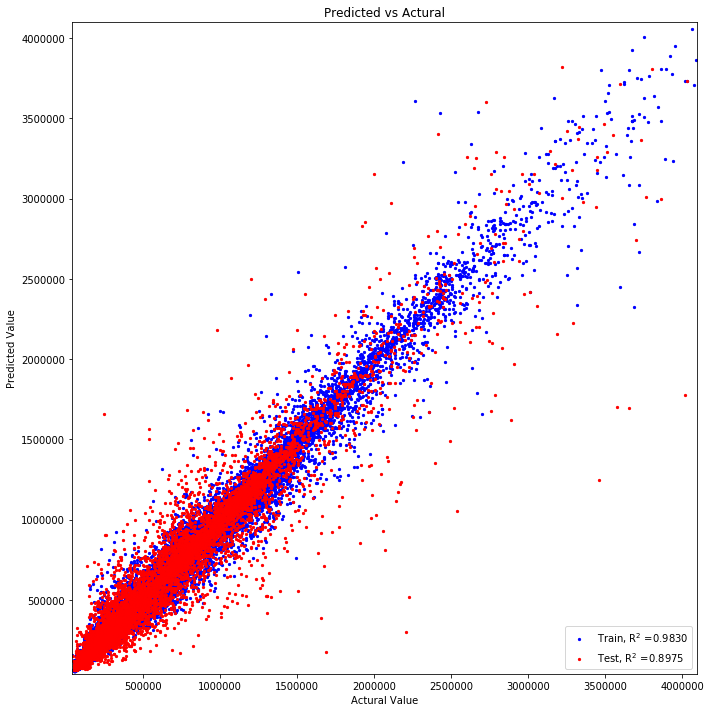

In [65]:
from sklearn.metrics import r2_score
y_train_predict = regr.predict(X_train)
y_train_test = regr.predict(X_test)
train_score = r2_score(y_train, y_train_predict)
test_score = r2_score(y_test, y_train_test)

plt.rcParams["figure.figsize"] = (10, 10) # (w, h)
fig, ax = plt.subplots()
plt.scatter(y_train, y_train_predict, s=5, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test, y_train_test, s=5, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((np.min(y),8*np.median(y)))
plt.ylim((np.min(y),8*np.median(y)))
ax.set_title('Predicted vs Actural')
ax.set_xlabel('Actural Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.tight_layout()
plt.savefig('./plot/'+'RF20_performance.png')


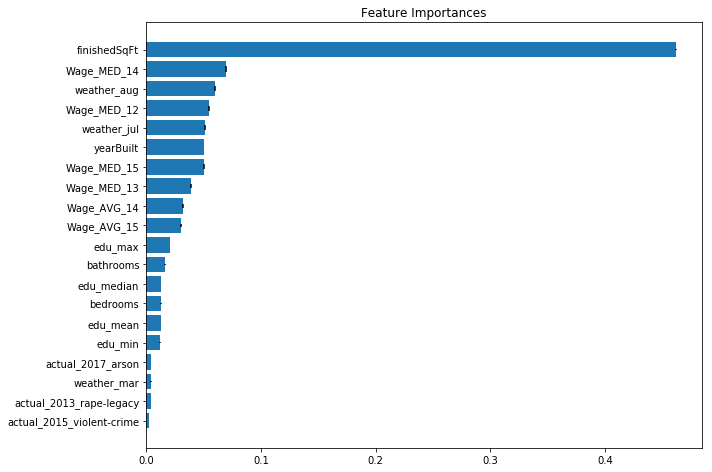

In [66]:
# rank feature inportance
num_features = 20
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/3) # (w, h)
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features], var_imp_sorted[:num_features],
        yerr=std[indices][:num_features], ecolor='black',
        color = None, align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances')
plt.tight_layout()
plt.savefig('./plot/'+'RF20_feature_imp.png')

In [12]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(regr)

In [49]:
# Calculate shap_values
num_shap = 500
shap_values = explainer.shap_values(X_train[:num_shap])

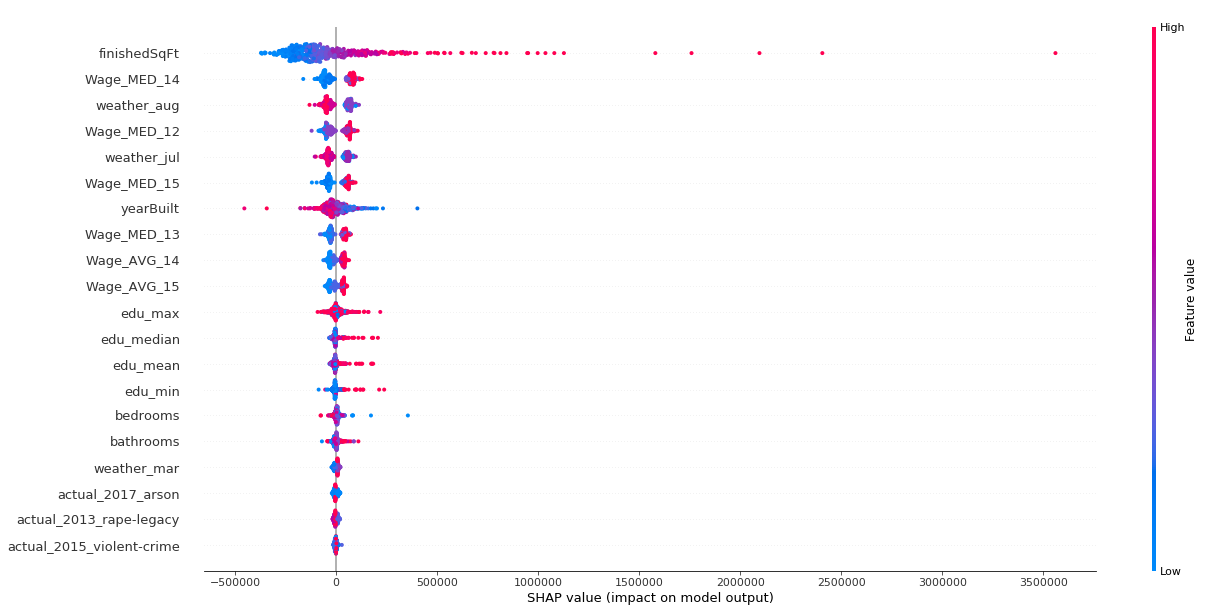

In [57]:
# plot
shap.summary_plot(shap_values, X_train[:num_shap],
                  plot_size=(20,10),#'auto'
                  show=False
                 )
plt.savefig("./plot/RF20_shap.png")